<a href="https://colab.research.google.com/github/alessandronicolini/IncrementalLearning/blob/main/LearningWithoutForgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# upload work files from your git hub repository
import sys
 
!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb
 
path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')
 
!pip3 install import_ipynb

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 405 (delta 76), reused 0 (delta 0), pack-reused 274
Receiving objects: 100% (405/405), 295.88 KiB | 9.86 MiB/s, done.
Resolving deltas: 100% (220/220), done.
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=4ed1270e19b75e12b5fbe8f4cda87fecb539e3c74066521d10cd4e90c8ee087c
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [2]:
import torch
import os
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
import torch.optim as optim
from torchvision import transforms
import numpy as np
import import_ipynb
import copy
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# project classes --------------------------------------------------------------
from IncrementalLearning.cifar100 import ilCIFAR100
from IncrementalLearning.resnet_cifar import resnet32
from tqdm.notebook import tqdm

importing Jupyter notebook from /content/IncrementalLearning/cifar100.ipynb


Extracting ./data/cifar-100-python.tar.gz to ./data
importing Jupyter notebook from /content/IncrementalLearning/resnet_cifar.ipynb


In [7]:
class lwf(nn.Module):
  def __init__(self, randomseed):
    super(lwf, self).__init__()
    self.model=resnet32(num_classes=100).cuda()
    self.batch_size=128
    self.CLASSES_PER_BATCH=10
    self.NUM_BATCHES=10
    self.LR=2
    self.MOMENTUM=0.9
    self.WEIGHT_DECAY=1e-5
    self.MILESTONES=[49,63]
    self.GAMMA=0.2
    self.numepochs=70
    self.randomseed=randomseed
    self.trainloader=None
    self.testloader=None
    self.original_training_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed)
    self.original_test_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train=False)
    self.criterion=nn.BCEWithLogitsLoss()
   
    
    self.firstbatch=1
    self.classes_seen=0
    self.diz = self.original_training_set.get_dict()
 
    # for confusion matrix computation
    self.y_test = []
    self.y_pred = []
 
  def forward(self, x):
 
    self.model = self.model.cuda()
    return self.model.forward(x)
 
 
  def update_parameters(self):
 
    old_model = copy.deepcopy(self)
    old_model.eval()
    old_model.to('cuda')
    n_classes=self.classes_seen+self.CLASSES_PER_BATCH
    print(n_classes)
    optimizer = optim.SGD(self.model.parameters(), lr=self.LR, momentum=self.MOMENTUM, weight_decay=self.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.MILESTONES, gamma=self.GAMMA)
    
    for epoch in tqdm(range(self.numepochs)):
 
      for _, inputs,labels in self.trainloader:
        inputs = inputs.cuda()
        labels = torch.tensor([self.diz[c.item()] for c in labels])
 
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs=self.forward(inputs)
        labels_encoded = F.one_hot(labels, 100).float().cuda() #CAMBIARE ONE_HOT
        
        if self.classes_seen:
          old_target = old_model.forward(inputs).cuda()
          old_target = torch.sigmoid(old_target).cuda()
          target = torch.cat((old_target[:,:self.classes_seen], labels_encoded[:, self.classes_seen:]), dim=1)
          loss = self.criterion(outputs, target)
        else:
          loss=self.criterion(outputs,labels_encoded) 
 
        loss.backward()
        optimizer.step()
      
      scheduler.step()
 
 
  def __accuracy_on(self, dl, model, mapper, last_test=False):
    
    total = 0.0
    correct = 0.0
 
    for  _, images, labels in dl:
      labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
      labels = labels.cuda()
      images = images.cuda()
      outputs = self.forward(images)
      _, preds = torch.max(outputs, dim=1)
      total += len(labels)
      correct += torch.sum(preds == labels).item()
 
      if last_test:
        self.y_pred += preds.tolist()
        self.y_test += labels.tolist()
 
    acc = 100 * correct / total
    return acc
 
 
  def plot_confusion_matrix(self):
 
    cm = confusion_matrix(self.y_test, self.y_pred)
    cm = np.log(cm+1)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, square=True, cbar=False, ax=ax, cmap=plt.get_cmap('seismic'))
    ax.set_xticks(np.linspace(19,99,5))
    ax.set_yticks(np.linspace(19,99,5))
    ax.set_xticklabels([20,40,60,80,100], rotation=0)
    ax.set_yticklabels([20,40,60,80,100], rotation=0)
    ax.set_title("LwF")
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    plt.savefig("LwF_"+str(self.randomseed)+"_cm.png")
    plt.show()
    return cm
 
 
  def training_model(self):
    
    train_indices = self.original_training_set.get_batch_indexes()
    test_indices = self.original_test_set.get_batch_indexes()
    current_test_indexes = []
    
    test_acc = []
    last_test = False
 
    for i in range(self.NUM_BATCHES):
      if i == self.NUM_BATCHES-1:
        last_test = True
      train_dataset = Subset(self.original_training_set,train_indices[i])
      current_test_indexes += test_indices[i].tolist()
      test_dataset = Subset(self.original_test_set,current_test_indexes)
      self.trainloader = DataLoader(train_dataset, batch_size = self.batch_size, shuffle=True)
      self.testloader = DataLoader(test_dataset, batch_size = self.batch_size, shuffle=True)        
      self.train()
      self.update_parameters()    
      self.classes_seen += 10
      self.eval() # Set Network to evaluation mode
      print('accuracy on training set:', self.__accuracy_on(self.trainloader, self, self.diz))
      current_test_acc = self.__accuracy_on(self.testloader, self, self.diz, last_test)
      print('accuracy on test set:', current_test_acc)
      print('-' * 80)
      test_acc.append(current_test_acc)
    
    # compute comfusion matrix and save results
    cm = self.plot_confusion_matrix()
    with open('LwF_'+str(self.randomseed)+"_cm", 'wb') as file:
      pickle.dump(cm, file, protocol=pickle.HIGHEST_PROTOCOL)
    with open('LwF_'+str(self.randomseed)+"_testacc", 'wb') as file:
      pickle.dump(test_acc, file, protocol=pickle.HIGHEST_PROTOCOL)
 
    return self

Files already downloaded and verified
Files already downloaded and verified
10



accuracy on training set: 95.76
accuracy on test set: 83.0
--------------------------------------------------------------------------------
20



accuracy on training set: 94.72
accuracy on test set: 64.4
--------------------------------------------------------------------------------
30



accuracy on training set: 93.32
accuracy on test set: 53.96666666666667
--------------------------------------------------------------------------------
40



accuracy on training set: 89.5
accuracy on test set: 47.425
--------------------------------------------------------------------------------
50



accuracy on training set: 86.78
accuracy on test set: 39.54
--------------------------------------------------------------------------------
60



accuracy on training set: 89.38
accuracy on test set: 38.93333333333333
--------------------------------------------------------------------------------
70



accuracy on training set: 87.5
accuracy on test set: 34.214285714285715
--------------------------------------------------------------------------------
80



accuracy on training set: 84.12
accuracy on test set: 30.1
--------------------------------------------------------------------------------
90



accuracy on training set: 87.14
accuracy on test set: 26.022222222222222
--------------------------------------------------------------------------------
100



accuracy on training set: 86.12
accuracy on test set: 24.8
--------------------------------------------------------------------------------


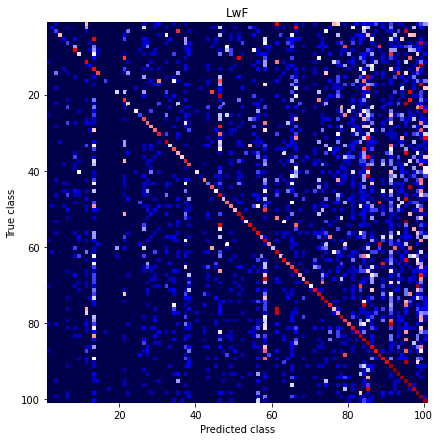

lwf(
  (model): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=

In [8]:
model=lwf(randomseed=203).cuda()
model.training_model()